In [1]:
import os
os.chdir("../..")

In [2]:
import torch
from utils.dataset_loader import *
from utils.model_utils import *
from utils.train_utils import *
from utils.metrics import *
from utils.visualization import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

[INFO] Using device: cuda


In [4]:
data_dir = "wildfire_dataset_scaled"
batch_size = 16
learning_rate = 0.0004
num_classes = 2
model_name = "resnet18"
output_dir = "outputs/models/augmented"
metrics_output_dir = "outputs/plots/augmented"
os.makedirs(output_dir, exist_ok=True)


In [5]:
print("[INFO] Loading augmented datasets...")
train_loader, val_loader, test_loader = load_datasets(
    data_dir=data_dir, batch_size=batch_size, augmentation="augmented"
)
print("[INFO] Augmented datasets loaded successfully!")

2024-12-23 21:40:34,138 - INFO - Loading datasets from wildfire_dataset_scaled with augmentation type 'augmented'.
2024-12-23 21:40:34,139 - INFO - Applying selected augmentations for wildfire scenarios.
2024-12-23 21:40:34,153 - INFO - Initialized AlbumentationsDataset with root: wildfire_dataset_scaled/train
2024-12-23 21:40:34,157 - INFO - Initialized AlbumentationsDataset with root: wildfire_dataset_scaled/val
2024-12-23 21:40:34,161 - INFO - Initialized AlbumentationsDataset with root: wildfire_dataset_scaled/test
2024-12-23 21:40:34,163 - INFO - Datasets initialized. Preparing DataLoaders...
2024-12-23 21:40:34,163 - INFO - Using WeightedRandomSampler for class balancing.
2024-12-23 21:40:34,164 - INFO - Computing class weights from directory: wildfire_dataset_scaled/train
2024-12-23 21:40:34,166 - INFO - Class 'fire' has 730 samples.
2024-12-23 21:40:34,168 - INFO - Class 'nofire' has 1157 samples.
2024-12-23 21:40:34,169 - INFO - Computed class weights: {'fire': 1.0, 'nofire': 

[INFO] Loading augmented datasets...


2024-12-23 21:40:47,177 - INFO - DataLoaders created successfully.


[INFO] Augmented datasets loaded successfully!


In [6]:
# Initialize the model
print(f"\n[INFO] Starting Training for Model: {model_name} with Augmented Data\n")
print(f"[INFO] Initializing {model_name} model...")
model = initialize_model(
    model_name=model_name,
    num_classes=num_classes,
    pretrained=True,
    freeze_all=True  # Baseline augmentation: Freeze all layers
)
print("[INFO] Model initialized successfully!")


[INFO] Starting Training for Model: resnet18 with Augmented Data

[INFO] Initializing resnet18 model...
[INFO] Model initialized successfully!


In [7]:
# Define loss function and optimizer
print("[INFO] Setting up loss function and optimizer...")
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
print("[INFO] Loss function and optimizer set up!")

[INFO] Setting up loss function and optimizer...
[INFO] Loss function and optimizer set up!


In [8]:
# Train the model

from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
print("[INFO] Starting model training with augmented data...")
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,  # No LR scheduler for augmented baseline
    device=device,
    save_path=os.path.join(output_dir, f"{model_name}_augmented.pt"),
    early_stop_patience=12,  # Early stopping patience
    monitor_metric="val_f1"
)
print("[INFO] Training completed successfully!")

[INFO] Starting model training with augmented data...

Starting training...



[INFO] Learning rate adjusted to: 0.000400
[INFO] Best model saved with val_f1: 0.7452
Epoch [1]: Train Loss: 0.7274, Train Acc: 0.5819 | Val Loss: 0.5551, Val Acc: 0.7040, Val Recall: 0.7073, Val F1: 0.7452


[INFO] Learning rate adjusted to: 0.000400
[INFO] Best model saved with val_f1: 0.8218
Epoch [2]: Train Loss: 0.5616, Train Acc: 0.7069 | Val Loss: 0.4871, Val Acc: 0.7562, Val Recall: 0.9187, Val F1: 0.8218


[INFO] Learning rate adjusted to: 0.000400
[INFO] Best model saved with val_f1: 0.8438
Epoch [3]: Train Loss: 0.5099, Train Acc: 0.7435 | Val Loss: 0.4557, Val Acc: 0.8085, Val Recall: 0.8455, Val F1: 0.8438


[INFO] Learning rate adjusted to: 0.000400
[INFO] Best model saved with val_f1: 0.8474
Epoch [4]: Train Loss: 0.5103, Train Acc: 0.7525 | Val Loss: 0.4342, Val Acc: 0.8109, Val Recall: 0.8577, Val F1: 0.8474


[INFO] Learning rate adjusted to: 0.000200
[INFO] Best model saved with val_f1: 0.8502
Epoch [5]: Train Loss: 0.4934, Train Acc: 0.7647 | Val Loss: 0.4256, Val Acc: 0.8010, Val Recall: 0.9228, Val F1: 0.8502


[INFO] Learning rate adjusted to: 0.000200
[INFO] No improvement in val_f1. Patience: 1/12
Epoch [6]: Train Loss: 0.4877, Train Acc: 0.7663 | Val Loss: 0.4253, Val Acc: 0.7935, Val Recall: 0.8577, Val F1: 0.8356


[INFO] Learning rate adjusted to: 0.000200
[INFO] Best model saved with val_f1: 0.8550
Epoch [7]: Train Loss: 0.4752, Train Acc: 0.7631 | Val Loss: 0.4289, Val Acc: 0.8109, Val Recall: 0.9106, Val F1: 0.8550


[INFO] Learning rate adjusted to: 0.000200
[INFO] No improvement in val_f1. Patience: 1/12
Epoch [8]: Train Loss: 0.4502, Train Acc: 0.7859 | Val Loss: 0.4361, Val Acc: 0.8109, Val Recall: 0.8171, Val F1: 0.8410


[INFO] Learning rate adjusted to: 0.000200
[INFO] No improvement in val_f1. Patience: 2/12
Epoch [9]: Train Loss: 0.4905, Train Acc: 0.7732 | Val Loss: 0.4298, Val Acc: 0.8209, Val Recall: 0.8374, Val F1: 0.8512


[INFO] Learning rate adjusted to: 0.000100
[INFO] No improvement in val_f1. Patience: 3/12
Epoch [10]: Train Loss: 0.4608, Train Acc: 0.7875 | Val Loss: 0.4000, Val Acc: 0.8035, Val Recall: 0.8740, Val F1: 0.8448


[INFO] Learning rate adjusted to: 0.000100
[INFO] No improvement in val_f1. Patience: 4/12
Epoch [11]: Train Loss: 0.4479, Train Acc: 0.7965 | Val Loss: 0.4178, Val Acc: 0.7985, Val Recall: 0.8130, Val F1: 0.8316


[INFO] Learning rate adjusted to: 0.000100
[INFO] Best model saved with val_f1: 0.8554
Epoch [12]: Train Loss: 0.4505, Train Acc: 0.7870 | Val Loss: 0.4078, Val Acc: 0.8209, Val Recall: 0.8659, Val F1: 0.8554


[INFO] Learning rate adjusted to: 0.000100
[INFO] Best model saved with val_f1: 0.8616
Epoch [13]: Train Loss: 0.4377, Train Acc: 0.8007 | Val Loss: 0.4044, Val Acc: 0.8234, Val Recall: 0.8984, Val F1: 0.8616


[INFO] Learning rate adjusted to: 0.000100
[INFO] No improvement in val_f1. Patience: 1/12
Epoch [14]: Train Loss: 0.4717, Train Acc: 0.7785 | Val Loss: 0.4185, Val Acc: 0.8060, Val Recall: 0.8577, Val F1: 0.8440


[INFO] Learning rate adjusted to: 0.000050
[INFO] Best model saved with val_f1: 0.8619
Epoch [15]: Train Loss: 0.4576, Train Acc: 0.7801 | Val Loss: 0.4140, Val Acc: 0.8333, Val Recall: 0.8496, Val F1: 0.8619


[INFO] Learning rate adjusted to: 0.000050
[INFO] Best model saved with val_f1: 0.8723
Epoch [16]: Train Loss: 0.4440, Train Acc: 0.7901 | Val Loss: 0.4101, Val Acc: 0.8383, Val Recall: 0.9024, Val F1: 0.8723


[INFO] Learning rate adjusted to: 0.000050
[INFO] No improvement in val_f1. Patience: 1/12
Epoch [17]: Train Loss: 0.4444, Train Acc: 0.7949 | Val Loss: 0.4104, Val Acc: 0.8134, Val Recall: 0.8862, Val F1: 0.8532


[INFO] Learning rate adjusted to: 0.000050
[INFO] No improvement in val_f1. Patience: 2/12
Epoch [18]: Train Loss: 0.4381, Train Acc: 0.7928 | Val Loss: 0.4171, Val Acc: 0.8010, Val Recall: 0.8780, Val F1: 0.8438


[INFO] Learning rate adjusted to: 0.000050
[INFO] Best model saved with val_f1: 0.8792
Epoch [19]: Train Loss: 0.4301, Train Acc: 0.7939 | Val Loss: 0.3898, Val Acc: 0.8483, Val Recall: 0.9024, Val F1: 0.8792


[INFO] Learning rate adjusted to: 0.000025
[INFO] No improvement in val_f1. Patience: 1/12
Epoch [20]: Train Loss: 0.4496, Train Acc: 0.7907 | Val Loss: 0.4037, Val Acc: 0.8159, Val Recall: 0.8943, Val F1: 0.8560


[INFO] Learning rate adjusted to: 0.000025
[INFO] No improvement in val_f1. Patience: 2/12
Epoch [21]: Train Loss: 0.4416, Train Acc: 0.7928 | Val Loss: 0.4045, Val Acc: 0.8209, Val Recall: 0.9146, Val F1: 0.8621


[INFO] Learning rate adjusted to: 0.000025
[INFO] No improvement in val_f1. Patience: 3/12
Epoch [22]: Train Loss: 0.4197, Train Acc: 0.8087 | Val Loss: 0.3934, Val Acc: 0.8259, Val Recall: 0.8780, Val F1: 0.8606


[INFO] Learning rate adjusted to: 0.000025
[INFO] No improvement in val_f1. Patience: 4/12
Epoch [23]: Train Loss: 0.4276, Train Acc: 0.8002 | Val Loss: 0.3948, Val Acc: 0.8383, Val Recall: 0.8862, Val F1: 0.8703


[INFO] Learning rate adjusted to: 0.000025
[INFO] No improvement in val_f1. Patience: 5/12
Epoch [24]: Train Loss: 0.4460, Train Acc: 0.7838 | Val Loss: 0.4104, Val Acc: 0.8060, Val Recall: 0.8821, Val F1: 0.8477


[INFO] Learning rate adjusted to: 0.000013
[INFO] No improvement in val_f1. Patience: 6/12
Epoch [25]: Train Loss: 0.4642, Train Acc: 0.7774 | Val Loss: 0.3896, Val Acc: 0.8333, Val Recall: 0.9065, Val F1: 0.8694


[INFO] Learning rate adjusted to: 0.000013
[INFO] No improvement in val_f1. Patience: 7/12
Epoch [26]: Train Loss: 0.4556, Train Acc: 0.7859 | Val Loss: 0.3964, Val Acc: 0.8284, Val Recall: 0.8984, Val F1: 0.8650


[INFO] Learning rate adjusted to: 0.000013
[INFO] No improvement in val_f1. Patience: 8/12
Epoch [27]: Train Loss: 0.4443, Train Acc: 0.7954 | Val Loss: 0.3979, Val Acc: 0.8209, Val Recall: 0.9024, Val F1: 0.8605


[INFO] Learning rate adjusted to: 0.000013
[INFO] Best model saved with val_f1: 0.8797
Epoch [28]: Train Loss: 0.4411, Train Acc: 0.7864 | Val Loss: 0.3854, Val Acc: 0.8483, Val Recall: 0.9065, Val F1: 0.8797


[INFO] Learning rate adjusted to: 0.000013
[INFO] No improvement in val_f1. Patience: 1/12
Epoch [29]: Train Loss: 0.4463, Train Acc: 0.7859 | Val Loss: 0.4086, Val Acc: 0.8010, Val Recall: 0.8455, Val F1: 0.8387


[INFO] Learning rate adjusted to: 0.000006
[INFO] No improvement in val_f1. Patience: 2/12
Epoch [30]: Train Loss: 0.4459, Train Acc: 0.7859 | Val Loss: 0.3937, Val Acc: 0.8209, Val Recall: 0.8618, Val F1: 0.8548


[INFO] Learning rate adjusted to: 0.000006
[INFO] No improvement in val_f1. Patience: 3/12
Epoch [31]: Train Loss: 0.4316, Train Acc: 0.8119 | Val Loss: 0.3987, Val Acc: 0.8134, Val Recall: 0.8862, Val F1: 0.8532


[INFO] Learning rate adjusted to: 0.000006
[INFO] No improvement in val_f1. Patience: 4/12
Epoch [32]: Train Loss: 0.4407, Train Acc: 0.7997 | Val Loss: 0.4041, Val Acc: 0.8159, Val Recall: 0.9228, Val F1: 0.8598


[INFO] Learning rate adjusted to: 0.000006
[INFO] No improvement in val_f1. Patience: 5/12
Epoch [33]: Train Loss: 0.4478, Train Acc: 0.7880 | Val Loss: 0.4128, Val Acc: 0.8184, Val Recall: 0.8780, Val F1: 0.8554


[INFO] Learning rate adjusted to: 0.000006
[INFO] No improvement in val_f1. Patience: 6/12
Epoch [34]: Train Loss: 0.4651, Train Acc: 0.7758 | Val Loss: 0.4044, Val Acc: 0.8234, Val Recall: 0.8780, Val F1: 0.8588


[INFO] Learning rate adjusted to: 0.000003
[INFO] No improvement in val_f1. Patience: 7/12
Epoch [35]: Train Loss: 0.4064, Train Acc: 0.8209 | Val Loss: 0.4102, Val Acc: 0.8184, Val Recall: 0.8618, Val F1: 0.8531


[INFO] Learning rate adjusted to: 0.000003
[INFO] No improvement in val_f1. Patience: 8/12
Epoch [36]: Train Loss: 0.4463, Train Acc: 0.7954 | Val Loss: 0.3916, Val Acc: 0.8259, Val Recall: 0.8577, Val F1: 0.8577


[INFO] Learning rate adjusted to: 0.000003
[INFO] No improvement in val_f1. Patience: 9/12
Epoch [37]: Train Loss: 0.4466, Train Acc: 0.7870 | Val Loss: 0.4021, Val Acc: 0.8284, Val Recall: 0.9065, Val F1: 0.8660


[INFO] Learning rate adjusted to: 0.000003
[INFO] No improvement in val_f1. Patience: 10/12
Epoch [38]: Train Loss: 0.4444, Train Acc: 0.7928 | Val Loss: 0.4054, Val Acc: 0.8234, Val Recall: 0.8862, Val F1: 0.8600


[INFO] Learning rate adjusted to: 0.000003
[INFO] No improvement in val_f1. Patience: 11/12
Epoch [39]: Train Loss: 0.4409, Train Acc: 0.7912 | Val Loss: 0.4125, Val Acc: 0.8159, Val Recall: 0.8780, Val F1: 0.8538


[INFO] Learning rate adjusted to: 0.000002
[INFO] No improvement in val_f1. Patience: 12/12
Epoch [40]: Train Loss: 0.4608, Train Acc: 0.7785 | Val Loss: 0.4048, Val Acc: 0.8134, Val Recall: 0.8577, Val F1: 0.8491
[INFO] Final metrics saved to outputs/models/augmented\final_metrics.json
[INFO] Training stopped after 40 epochs. Best val_f1: 0.8797

[INFO] Training completed successfully!


In [9]:
# Evaluate the model
print("[INFO] Evaluating the model...")
metrics = evaluate_model(
    model=model,
    test_loader=test_loader,
    classes=["No Fire", "Fire"],
    device=device,
    model_name=model_name,
    save_base_path=metrics_output_dir + f"/{model_name}_augmented"
)
print(f"\n[INFO] Metrics for {model_name} with Augmented Data:\n{metrics}")

[INFO] Evaluating the model...
[INFO] Evaluation metrics saved to outputs/plots/augmented/resnet18_augmented\resnet18\resnet18_evaluation.json

[INFO] Metrics for resnet18 with Augmented Data:
{'classification_report': {'No Fire': {'precision': 0.8424242424242424, 'recall': 0.8742138364779874, 'f1-score': 0.8580246913580247, 'support': 159.0}, 'Fire': {'precision': 0.9183673469387755, 'recall': 0.896414342629482, 'f1-score': 0.907258064516129, 'support': 251.0}, 'accuracy': 0.8878048780487805, 'macro avg': {'precision': 0.880395794681509, 'recall': 0.8853140895537348, 'f1-score': 0.8826413779370769, 'support': 410.0}, 'weighted avg': {'precision': 0.8889162405538712, 'recall': 0.8878048780487805, 'f1-score': 0.8881651222426202, 'support': 410.0}}, 'confusion_matrix': [[139, 20], [26, 225]], 'roc_auc': 0.9480568292866272, 'y_true': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[INFO] Saving training and evaluation results...
[INFO] Training plot saved to outputs/plots/augmented\resnet18_augmented_training_curve.png
[INFO] Confusion matrix saved to outputs/plots/augmented\resnet18_augmented_confusion_matrix.png
[INFO] ROC curve saved to outputs/plots/augmented\resnet18_augmented_roc_curve.png
[INFO] Precision-Recall curve saved to outputs/plots/augmented\resnet18_augmented_precision_recall.png
[INFO] All results saved successfully!


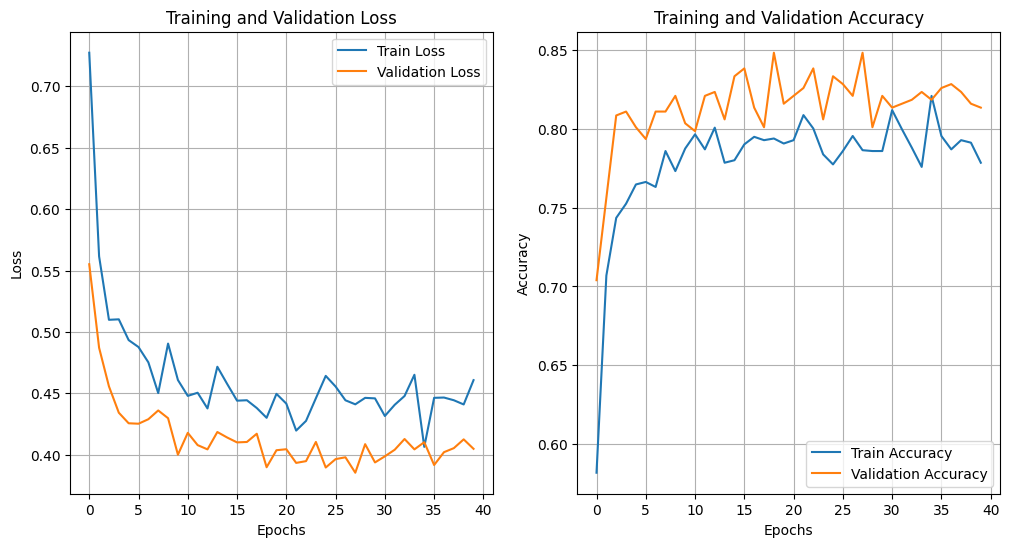

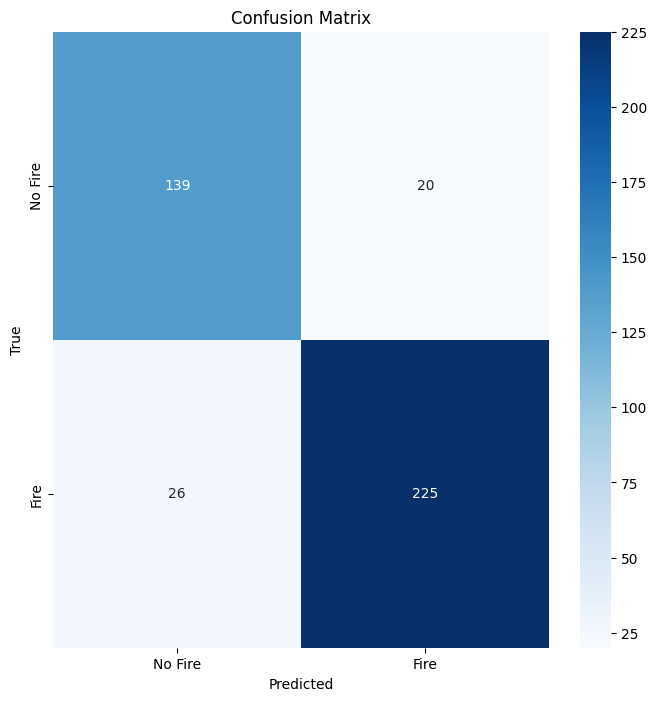

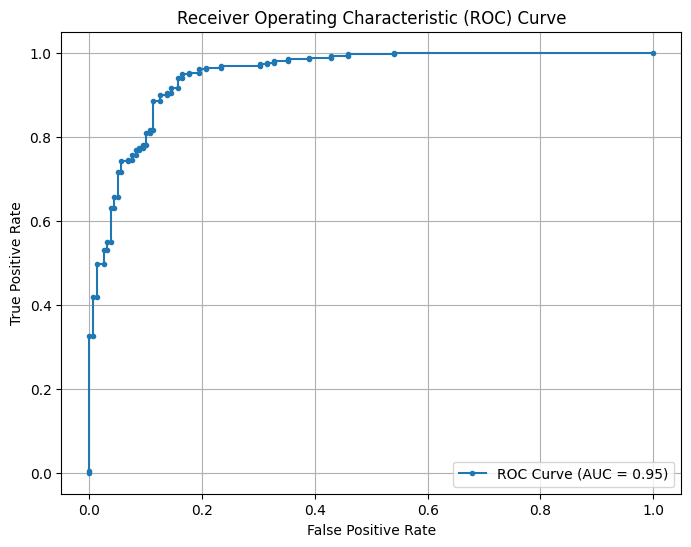

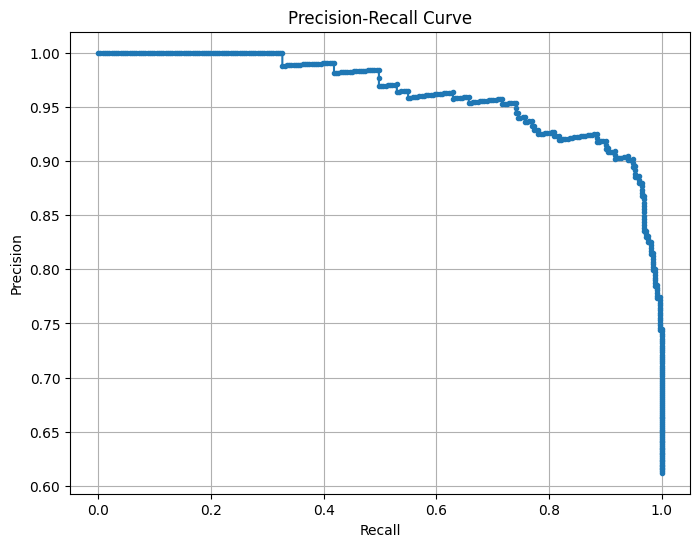

In [10]:
print("[INFO] Saving training and evaluation results...")

# Training curve
plot_training(
    history, output_path=os.path.join(metrics_output_dir, f"{model_name}_augmented_training_curve.png")
)

# Confusion matrix
plot_confusion_matrix(
    cm=metrics["confusion_matrix"],
    classes=["No Fire", "Fire"],
    output_path=os.path.join(metrics_output_dir, f"{model_name}_augmented_confusion_matrix.png")
)

# ROC Curve
plot_roc_curve(
    y_true=metrics["y_true"],
    y_scores=metrics["y_scores"],
    output_path=os.path.join(metrics_output_dir, f"{model_name}_augmented_roc_curve.png")
)

# Precision-Recall Curve
plot_precision_recall(
    y_true=metrics["y_true"],
    y_scores=metrics["y_scores"],
    output_path=os.path.join(metrics_output_dir, f"{model_name}_augmented_precision_recall.png")
)

print("[INFO] All results saved successfully!")